## Fake News Classification Project

In [1]:
# =========================
# 0. Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

# Transformers for BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import Dataset

# Data augmentation
from nltk.corpus import wordnet
import random

# Download NLTK packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/liubov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/liubov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/liubov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1. EDA (Exploratory Data Analysis)

- Preview the dataset.
- Check for missing values.
- Analyze text and title lengths.
- Examine class balance (is_fake).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44680 entries, 0 to 44679
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44680 non-null  object
 1   text     44680 non-null  object
 2   date     44680 non-null  object
 3   is_fake  44680 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB
None
            is_fake
count  44680.000000
mean       0.525269
std        0.499367
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
title      0
text       0
date       0
is_fake    0
dtype: int64


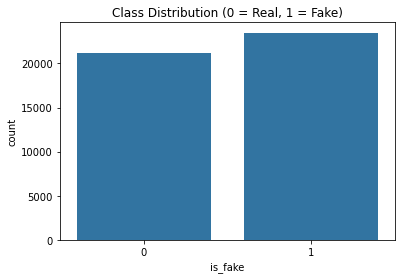

In [2]:
# Load dataset
df = pd.read_csv('/home/liubov/Téléchargements/fake_news_full_data.csv')

# Drop unnecessary column
df = df.drop(columns=['Unnamed: 0'])

# Basic info
print(df.info())
print(df.describe())

# Missing values
print(df.isnull().sum())

# Class balance
sns.countplot(data=df, x='is_fake')
plt.title('Class Distribution (0 = Real, 1 = Fake)')
plt.show()


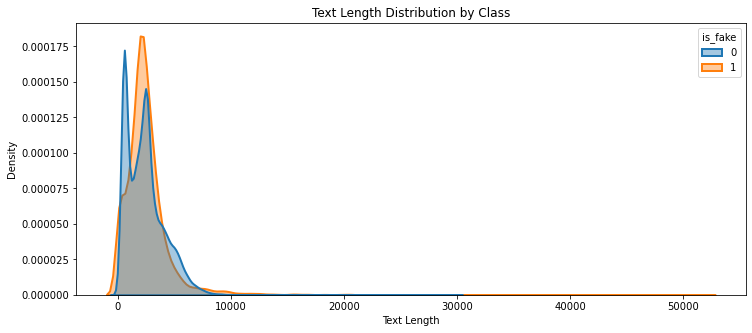

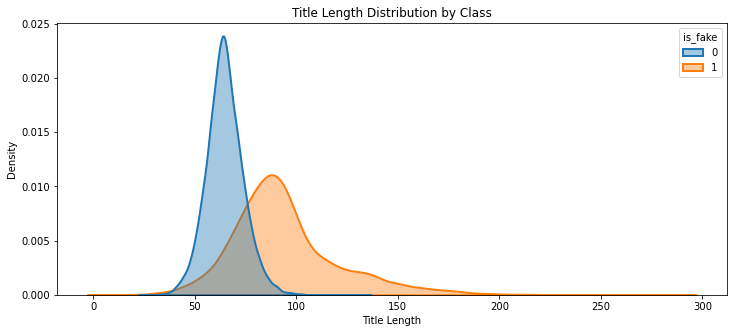

In [3]:
df['text_len'] = df['text'].str.len()
df['title_len'] = df['title'].str.len()

plt.figure(figsize=(12,5))
sns.kdeplot(data=df, x='text_len', hue='is_fake', fill=True, alpha=0.4, linewidth=2)
plt.xlabel('Text Length')
plt.title('Text Length Distribution by Class')
plt.show()

plt.figure(figsize=(12,5))
sns.kdeplot(data=df, x='title_len', hue='is_fake', fill=True, alpha=0.4, linewidth=2)
plt.xlabel('Title Length')
plt.title('Title Length Distribution by Class')
plt.show()


### 2. Text Preprocessing

- Convert text to lowercase
- Remove special characters/punctuation
- Tokenization
- Lemmatization
- Remove stopwords (optional, useful for BoW/TF-IDF models)

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text) # remove URLs
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'[^a-z\s]', '', text) # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # remove extra spaces
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['text_clean'] = df['text'].apply(preprocess)


In [5]:
df['text_clean']

0        london reuters magnitude earthquake hit coast ...
1        hill released controversial comment sore loser...
2        reuters former u house speaker dennis hastert ...
3        bucharest reuters romanian protester clashed r...
4        united nation reuters democratic republic cong...
                               ...                        
44675    washington reuters new york attorney general o...
44676    michelle obama received million dollar fed pet...
44677    discovered austen fletcher yet please check tw...
44678    great someone government would take import tho...
44679    american right defend banning one type gun lea...
Name: text_clean, Length: 44680, dtype: object

In [6]:
def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([w for w in words if wordnet.synsets(w)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym_words = synonyms[0].lemma_names()
            if synonym_words:
                new_words = [synonym_words[0] if w==random_word else w for w in new_words]
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

# Apply augmentation to fake news only
fake_df = df[df['is_fake']==1].copy()
augmented_texts = fake_df['text_clean'].apply(lambda x: synonym_replacement(x, n=2))
augmented_df = fake_df.copy()
augmented_df['text_clean'] = augmented_texts

# Combine original + augmented
df_aug = pd.concat([df, augmented_df], ignore_index=True)

### 3. Feature Extraction

- Bag-of-Words / TF-IDF: for classic ML models
- Embeddings for deep learning:
- Word2Vec / GloVe for LSTM/CNN
- BERT embeddings or fine-tuning for transformers

In [7]:
df_aug['title_len'] = df_aug['title'].str.len()
df_aug['date'] = pd.to_datetime(df_aug['date'], errors='coerce')
df_aug['year'] = df_aug['date'].dt.year
df_aug['month'] = df_aug['date'].dt.month

# TF-IDF
X = df_aug['text_clean']
y = df_aug['is_fake']

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


In [23]:
df_aug.head()

,title,text,date,is_fake,text_len,title_len,text_clean,year,month
0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,2017-09-17,0,305,36,london reuters magnitude earthquake hit coast ...,2017.0,9.0
1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,NaT,1,1859,149,hill released controversial comment sore loser...,NaN,NaN
2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,2016-04-09,0,1995,61,reuters former u house speaker dennis hastert ...,2016.0,4.0
3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,2017-12-02,0,2082,62,bucharest reuters romanian protester clashed r...,2017.0,12.0
4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,2017-10-16,0,2513,59,united nation reuters democratic republic cong...,2017.0,10.0


### 4. Models 
(at least 3 different approaches)

- Baseline: Logistic Regression on TF-IDF
- More advanced classical model: RandomForest or XGBoost
- Deep Learning: LSTM / BERT fine-tuning


In [9]:
lr_params = {'C':[0.1,1,10], 'solver':['liblinear']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train, y_train)
y_pred_lr = lr_grid.predict(X_test)
print("Logistic Regression F1-score:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression F1-score: 0.9974988026182747
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4242
           1       1.00      1.00      1.00      9388

    accuracy                           1.00     13630
   macro avg       1.00      1.00      1.00     13630
weighted avg       1.00      1.00      1.00     13630



In [11]:
rf_params = {'n_estimators':[200,300], 'max_depth':[None,20,30], 'class_weight':['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_test)
print("Random Forest F1-score:", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest F1-score: 0.9993611584327087
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4242
           1       1.00      1.00      1.00      9388

    accuracy                           1.00     13630
   macro avg       1.00      1.00      1.00     13630
weighted avg       1.00      1.00      1.00     13630



In [12]:
ensemble_model = VotingClassifier(estimators=[
    ('lr', lr_grid.best_estimator_),
    ('rf', rf_grid.best_estimator_)
], voting='soft', n_jobs=-1)

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
print("Ensemble F1-score:", f1_score(y_test, y_pred_ensemble))


Ensemble F1-score: 0.9987227248536455


In [13]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [22]:
# # Use raw text, not TF-IDF
# X_train_texts = df_aug.loc[X_train.indices if hasattr(X_train, 'indices') else X_train.index, 'text'].tolist()
# X_test_texts = df_aug.loc[X_test.indices if hasattr(X_test, 'indices') else X_test.index, 'text'].tolist()
# y_train_list = y_train.tolist()
# y_test_list = y_test.tolist()

# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# MAX_LEN = 256

# train_dataset = NewsDataset(X_train_texts, y_train_list, tokenizer, MAX_LEN)
# test_dataset = NewsDataset(X_test_texts, y_test_list, tokenizer, MAX_LEN)

# bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


In [21]:
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=2,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     warmup_steps=50,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=50,
#     evaluation_strategy="steps",
#     save_strategy="no",
#     learning_rate=2e-5,
# )


In [20]:
# trainer = Trainer(
#     model=bert_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=tokenizer
# )

# trainer.train()


### 5. Model Evaluation

Use F1-score, accuracy, and confusion matrix. 
Compare results of 3 models and write conclusions.

In [17]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Ensemble', 'BERT Fine-Tuning'],
    'F1-score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_ensemble),
        'TBD after BERT training'
    ]
})
print(results)


                 Model                 F1-score
0  Logistic Regression                 0.997499
1        Random Forest                 0.999361
2             Ensemble                 0.998723
3     BERT Fine-Tuning  TBD after BERT training


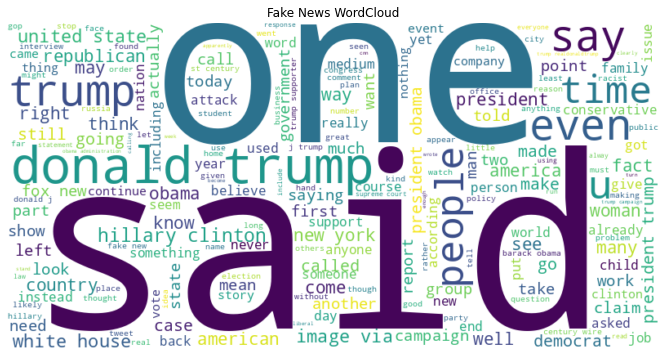

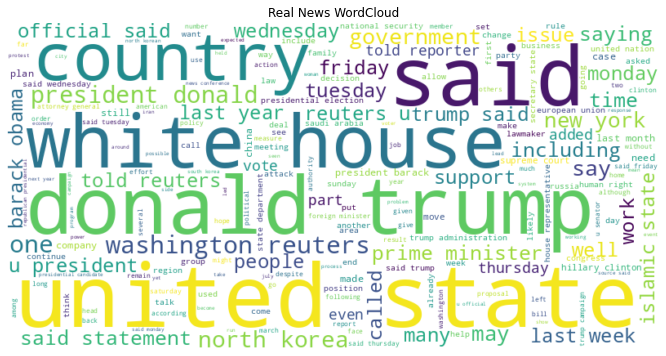

In [18]:
fake_text = ' '.join(df[df['is_fake']==1]['text_clean'])
real_text = ' '.join(df[df['is_fake']==0]['text_clean'])

plt.figure(figsize=(12,6))
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News WordCloud')
plt.show()

plt.figure(figsize=(12,6))
wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title('Real News WordCloud')
plt.show()


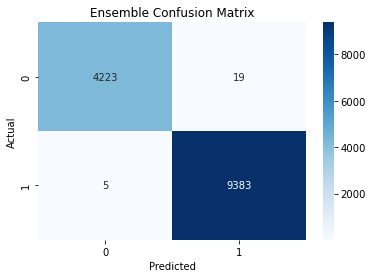

In [19]:
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Confusion Matrix')
plt.show()


In [ ]:
# Ideas to Improve Performance

# Data augmentation (paraphrasing texts)

# Model ensembles

# Additional features (text length, publication date)

# Custom transformers or DistilBERT for faster training